# AUDIO-DESCRIPTION-OF-IMAGE-FOR-VISUALLY-IMAPIRED

Let's start the Project

The Idea Behind the Project: <br>
    Image ---> Caption  ---> Audio

For converting the image to Caption we will use MultiModal technique of CNN-RNN architecture where we first built CNN model to get feature of the image and finally put the faeture as input to RNN(LSTM) Modal to predict the caption of image and finally convert that text to Audio.

For the image caption generator, we will be using the Flickr_8K dataset.

In [26]:
# Importing Libraries
import string
import numpy as np
from PIL import Image
import os
import matplotlib.pyplot as plt
%matplotlib inline

from pickle import dump, load
import numpy as np
from keras.applications.xception import Xception, preprocess_input
from keras.preprocessing.image import load_img, img_to_array
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers.merge import add
from keras.models import Model, load_model
from keras.layers import Input, Dense, LSTM, Embedding, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, LearningRateScheduler

# small library for seeing the progress of loops.
from tqdm.notebook import tqdm
tqdm().pandas()

|          | 0/? [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/tqdm/std.py:701: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


# Getting and cleaning the dataset

Each image has 5 captions and we can see that #(0 to 5)number is assigned for each caption.

### sample  Flickr8k.token dataset

1001773457_577c3a7d70.jpg#0 &emsp;	A black dog and a spotted dog are fighting <br>
1001773457_577c3a7d70.jpg#1 &emsp;	A black dog and a tri-colored dog playing with each other on the road .<br>
1001773457_577c3a7d70.jpg#2 &emsp;	A black dog and a white dog with brown spots are staring at each other in the street .<br>
1001773457_577c3a7d70.jpg#3 &emsp;	Two dogs of different breeds looking at each other on the road .<br>
1001773457_577c3a7d70.jpg#4 &emsp;	Two dogs on pavement moving toward each other .<br>
1002674143_1b742ab4b8.jpg#0 &emsp;	A little girl covered in paint sits in front of a painted rainbow with her hands in a bowl .<br>
1002674143_1b742ab4b8.jpg#1 &emsp;	A little girl is sitting in front of a large painted rainbow .<br>
1002674143_1b742ab4b8.jpg#2 &emsp;	A small girl in the grass plays with fingerpaints in front of a white canvas with a rainbow on it .<br>
1002674143_1b742ab4b8.jpg#3 &emsp;	There is a girl with pigtails sitting in front of a rainbow painting .<br>
1002674143_1b742ab4b8.jpg#4 &emsp;	Young girl with pigtails painting outside in the grass .<br>
1003163366_44323f5815.jpg#0 &emsp;	A man lays on a bench while his dog sits by him .<br>
1003163366_44323f5815.jpg#1 &emsp;	A man lays on the bench to which a white dog is also tied .<br>
1003163366_44323f5815.jpg#2 &emsp;	a man sleeping on a bench outside with a white and black dog sitting next to him .<br>
1003163366_44323f5815.jpg#3 &emsp;	A shirtless man lies on a park bench with his dog .<br>
1003163366_44323f5815.jpg#4 &emsp;	man laying on bench holding leash of dog sitting on ground<br>
1007129816_e794419615.jpg#0 &emsp;	A man in an orange hat starring at something .<br>
1007129816_e794419615.jpg#1 &emsp;	A man wears an orange hat and glasses .<br>
1007129816_e794419615.jpg#2 &emsp;	A man with gauges and glasses is wearing a Blitz hat .<br>
1007129816_e794419615.jpg#3 &emsp;	A man with glasses is wearing a beer can crocheted hat .<br>
1007129816_e794419615.jpg#4 &emsp;	The man with pierced ears is wearing glasses and an orange hat .<br>

In [2]:
# loading the file and reading a content as a string
def load_document(filename):
    file=open(filename,'r') #open file in read only mode
    text=file.read()        #reading the file content
    file.close()
    return text           # return the file content as a string

# mapping each image to their captions
def map_img_to_captions(filename):
    file=load_document(filename)
    captions=file.split('\n')
    img_to_its_caption={}    # dictionary that map the image with its caption
    for caption in captions[:-1]:
        img, caption = caption.split('\t')
        if img[:-2] not in img_to_its_caption:
            img_to_its_caption[img[:-2]]=[caption]
        else:
            img_to_its_caption[img[:-2]].append(caption)
    return img_to_its_caption
    

'''cleaning_text( descriptions)''' –  function takes all descriptions and performs cleaning on caption. This is an important step when we work with textual data, according to our goal, we decide what type of cleaning we want to perform on the text. In our case, we will be removing punctuations, converting all text to lowercase and removing words that contain numbers.
So, a caption like “A man riding on a three-wheeled wheelchair” will be transformed into “man riding on three wheeled wheelchair”

In [3]:
#Data cleaning- function for cleaning text like lower casing, removing puntuations and words containing numbers
  #string.punctuation gives all set of punctuation
def preprocessing_text(captions):
    # punctuation is mapped to none
    table=str.maketrans('','',string.punctuation)  #The string maketrans() method returns a mapping table for translation usable for translate() method
    for img,caps in captions.items():
        for i,img_caption in enumerate(caps):
            
            img_caption.replace("-"," ")
            cleaned_text = img_caption.split()
            
            #convert each caption to lowercase
            cleaned_text=[word.lower() for word in cleaned_text]
            
            #remove punctuation from each token
            cleaned_text=[word.translate(table) for word in cleaned_text]
            
            #remove hanging 's and a 
            cleaned_text = [word for word in cleaned_text if(len(word)>1)]
            
            #remove tokens with numbers in them
            cleaned_text = [word for word in cleaned_text if(word.isalpha())]
            #convert back to string
            img_caption = ' '.join(cleaned_text)
            captions[img][i]= img_caption
            
    return captions

Let's visulize an example image and its caption


In [4]:
pwd

'/kaggle/working'

In [5]:
# function that will separate all the unique words and create the vocabulary from all the descriptions.
def text_vocabulary(descriptions):
    # build vocabulary of all unique words
    vocabulary=set()
    for key in descriptions.keys():
        [vocabulary.update(d.split()) for d in descriptions[key]]
        
    return vocabulary

# Saving clean and processed descriptions in one file
def saving_descriptions(descriptions,filename):
    captions=list()
    for key,cap_list in descriptions.items():
        for caption in cap_list:
            captions.append(key+'\t'+caption)
            
    data="\n".join(captions)
    file=open(filename,'w')
    file.write(data)
    file.close()
    

In [6]:
# We will define all the paths to the files that we require and save the images id and their captions.

dataset_text = '../input/flickr8k-imageswithcaptions/Flickr8k_text/'
dataset_images = '../input/flickr8k-imageswithcaptions/Flickr8k_Dataset/Flicker8k_Dataset/'

#we prepare our text data
filename = dataset_text  + "Flickr8k.token.txt"
#loading the file that contains all data
#mapping them into descriptions dictionary img to 5 captions
descriptions =  map_img_to_captions(filename)
print("Length of descriptions =" ,len(descriptions))

#cleaning the descriptions
clean_descriptions = preprocessing_text(descriptions)
#building vocabulary 
vocabulary = text_vocabulary(clean_descriptions)
print("Length of vocabulary = ", len(vocabulary))
#saving each description to file 
saving_descriptions(clean_descriptions, "descriptions.txt")

Length of descriptions = 8092
Length of vocabulary =  8763


# Extracting the feature vector from all images

Now , we will use Transfer Learning for determining the feature Vector from Pre-trained Model

We are using the Xception model which has been trained on imagenet dataset that had 1000 different classes to classify. `Since the Xception model was originally built for imagenet, we will do little changes for integrating with our model. One thing to notice is that the Xception model takes 299*299*3 image size as input. We will remove the last classification layer and get the 2048 feature vector.`

Xception Model is proposed by Francois Chollet. Xception is an extension of the inception Architecture which replaces the standard Inception modules with depthwise Separable Convolutions.


##### Xception Architecture

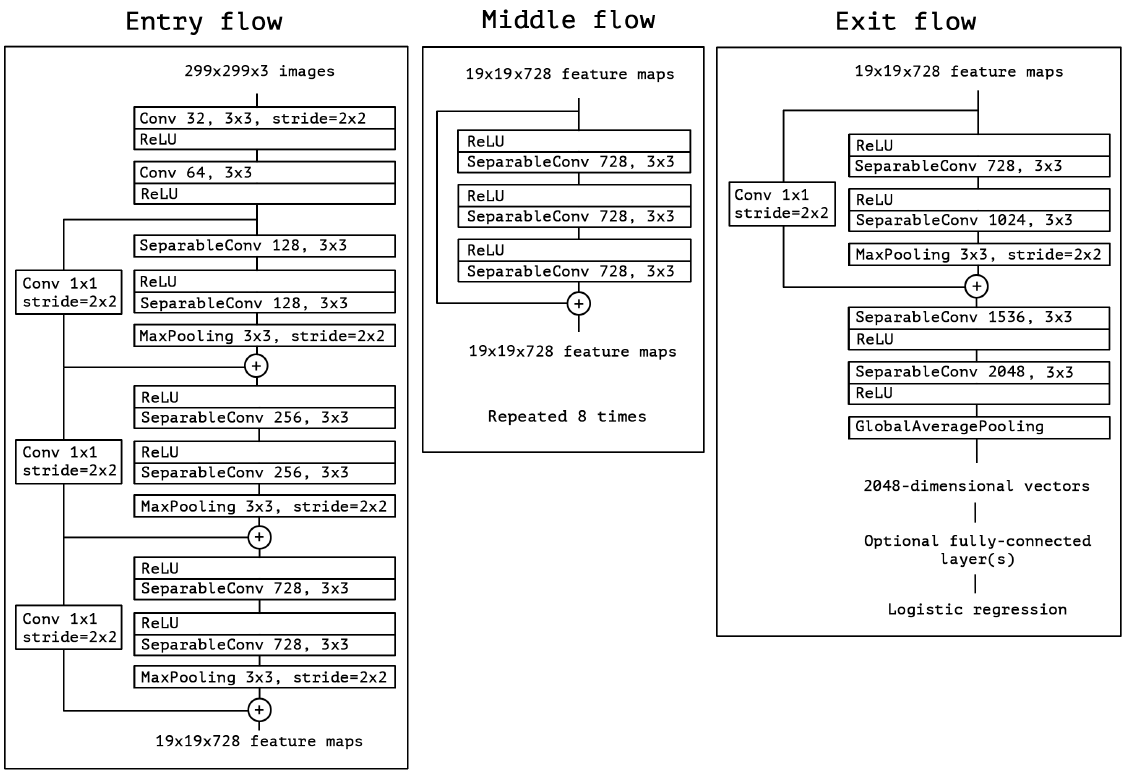

In [7]:
pwd

'/kaggle/working'

In [8]:
os.listdir()

['descriptions.txt', '__notebook_source__.ipynb']

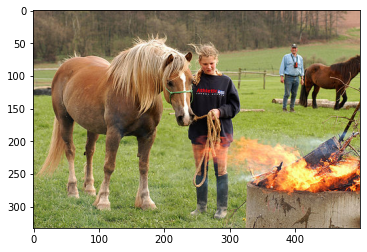

max_pixel= 255 min_pixel= 0


In [10]:
### Reading about particular image and its captions
x=plt.imread("../input/flickr8k-imageswithcaptions/Flickr8k_Dataset/Flicker8k_Dataset/10815824_2997e03d76.jpg")
plt.imshow(x)
plt.show()
print("max_pixel=",x.max(),"min_pixel=",x.min())

In [11]:
def extract_features(directory):
    XceptionModel=Xception(include_top=False,pooling='avg')
    features={}
    for img in tqdm(os.listdir(directory)):
        filename=directory + "/" +img
        image=Image.open(filename)      #Opens and identifies the given image file.
        image=image.resize((299,299))   # resizing the image to make as a input to Xception model
        #Expand the shape of an array.
        image=np.expand_dims(image,axis=0)  #Insert a new axis that will appear at the axis position in the expanded array shape.
        #normalizing the image
        image=image/255
        
        feature=XceptionModel.predict(image)
        features[img]=feature
    return features



In [ ]:
#2048 feature vector
features = extract_features(dataset_images)
dump(features, open("features.p","wb"))      # write in binary mode

# Load the Data for Training the Model.

***load_clean_caption( filename, photos )***– This function will create a dictionary that contains captions for each photo from the list of photos. Append the start and end identifier for each caption. We need this so that our LSTM model can identify the starting and ending of the caption.<br>
***load_features(photos)*** – This function will give us the dictionary for image names and their feature vector which we have previously extracted from the Xception model.

In [12]:
# load the text file in a string and will return the list of image names.
def load_photos(filename):
    file=load_document(filename)
    photos=file.split('\n')[:-1]
    return photos

def load_clean_caption(filename,photos):
    file=load_document(filename)
    map_img_to_caps={}           #dictionary that contains captions for each photo from the list of photos
    lines=file.split('\n')
    for line in lines:
        words=line.split()
        
        if len(words)<1:
            continue
            
        img,img_caption=words[0],words[1:]
        if img in photos:
            if img not in map_img_to_caps:
                map_img_to_caps[img] = []
            desc = '<start> ' + " ".join(img_caption) + ' <end>'
            map_img_to_caps[img].append(desc)
            
    return map_img_to_caps
    
def load_features(photos):
    #loading all features
    all_features=load(open("../input/model-requirments/features.p","rb"))   #load()-Decode the given Python file-like stream containing a JSON formatted value into Python object.
    #selecting only needed features for training dataset(only)
    features = {k:all_features[k] for k in photos}
    #print(features)
    return features
    

In [13]:
filename = dataset_text + "/" + "Flickr_8k.trainImages.txt"

train_imgs = load_photos(filename)
train_descriptions = load_clean_caption("descriptions.txt", train_imgs)
train_features = load_features(train_imgs)

In [14]:
print(train_features)

{'2513260012_03d33305cf.jpg': array([[0.        , 0.3994447 , 0.0023073 , ..., 0.24724662, 0.00611375,
        0.01884146]], dtype=float32), '2903617548_d3e38d7f88.jpg': array([[0.14825107, 0.00832609, 0.1061928 , ..., 0.09697428, 0.24103837,
        0.03163302]], dtype=float32), '3338291921_fe7ae0c8f8.jpg': array([[0.3214835 , 0.        , 0.00088849, ..., 0.        , 0.04906381,
        0.        ]], dtype=float32), '488416045_1c6d903fe0.jpg': array([[0.47706813, 0.        , 0.        , ..., 0.01351506, 0.        ,
        0.        ]], dtype=float32), '2644326817_8f45080b87.jpg': array([[0.00397643, 0.00182328, 0.0090278 , ..., 0.12199224, 0.01960842,
        0.00024491]], dtype=float32), '218342358_1755a9cce1.jpg': array([[0.02696379, 0.00088751, 0.07851785, ..., 0.22318082, 0.06492615,
        0.21575123]], dtype=float32), '2501968935_02f2cd8079.jpg': array([[0.19503945, 0.00038608, 0.30481285, ..., 0.00497419, 0.0119286 ,
        0.37110534]], dtype=float32), '2699342860_5288e203e

# Tokenizing the Vocabulary

We will map each word of the vocabulary with unique index value .Keras library provides us with the tokenizer function that we will use to create tokens from our vocabulary and save them to a “tokenizer.p” pickle file.

In [15]:
#converting dictionary to clean list of descriptions
def dict_to_list(descriptions):
    all_desc=[]
    for key in descriptions.keys():
        [all_desc.append(d) for d in descriptions[key]]
    return all_desc

In [16]:
all_desc=dict_to_list(train_descriptions)
print(len(all_desc))
print(all_desc[0:10])     # sample

30000
['<start> child in pink dress is climbing up set of stairs in an entry way <end>', '<start> girl going into wooden building <end>', '<start> little girl climbing into wooden playhouse <end>', '<start> little girl climbing the stairs to her playhouse <end>', '<start> little girl in pink dress going into wooden cabin <end>', '<start> black dog and spotted dog are fighting <end>', '<start> black dog and tricolored dog playing with each other on the road <end>', '<start> black dog and white dog with brown spots are staring at each other in the street <end>', '<start> two dogs of different breeds looking at each other on the road <end>', '<start> two dogs on pavement moving toward each other <end>']


In [17]:
#creating tokenizer class 
#this will vectorise text corpus
#each integer will represent token in dictionary

from keras.preprocessing.text import Tokenizer
def create_tokenizer(descriptions):
    desc_list=dict_to_list(descriptions)
    tokenizer=Tokenizer(filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',lower=True,split=" ",char_level=False)  # default parameters
    tokenizer.fit_on_texts(desc_list)
    print(tokenizer)
    return tokenizer

# give each word an index, and store that into tokenizer.p pickle file
tokenizer = create_tokenizer(train_descriptions)
dump(tokenizer,open('tokenizer.p','wb'))
vocab_size = len(tokenizer.word_index) + 1
print("len of vvocab:"+str(vocab_size))

len of vvocab:7577


Now calculate the maximum length of the descriptions.

In [18]:
def max_length(descriptions):
    desc_list = dict_to_list(descriptions)
    for d in descriptions:
        return max(len(d.split()) for d in desc_list)    # calculating maximum of all list length
    
max_length = max_length(descriptions)
max_length


32

In [19]:
tokenize_text=load(open("tokenizer.p","rb"))      # read in binary mode of tokenized text

In [20]:
#print(tokenize_text.word_index)   # prinitng the tokenized dictionary

# Create data generator

* As this is a supervised learning Task we have to provide input an output to the model.
* We have to train our model on 6000 images and each image will contain 2048 length feature vector and caption is also represented as numbers
* This large amount of data is not possilble to store in the memory.So ,we have to use a geneartor method that will yield batches.

The input to our model is [x1, x2] and the output will be y, where x1 is the 2048 feature vector of that image, x2 is the input text sequence and y is the output text sequence that the model has to predict.

In [21]:
#create input-output sequence pairs from the image description.

def create_sequences(tokenizer,max_length,desc_list,feature):
    X1, X2, y = list(), list(), list()
    # looping through each description of  an image
    for desc in desc_list:
        #encoding the sequence
        seq=tokenizer.texts_to_sequences([desc])[0]
        #print(seq,"seq")   # 5 list(5 captions) of 5 captions containing the words position in vocab.
        for i in range(1,len(seq)):  
            # split one Sequence into multiple X,y pairs
            in_seq,out_seq=seq[:i],seq[i]
#             print(in_seq,"in_seq")
#             print(out_seq,"out_seq")
            #pad input sequence
            in_seq=pad_sequences([in_seq],maxlen=max_length)[0]
            #encode output
            out_seq=to_categorical([out_seq],num_classes=vocab_size)[0]
            
            X1.append(feature)
            X2.append(in_seq)
            y.append(out_seq)
            
    return np.array(X1),np.array(X2),np.array(y)

`Yield` is a keyword in Python that is used to return from a function without destroying the states of its local variable and when the function is called, the execution starts from the last yield statement. Any function that contains a yield keyword is termed as generator. 

In [22]:
#data generator, used by model.fit_generator()

def data_generator(descriptions,features,tokenizer,max_len):
    while 1:
        for key,description_list in descriptions.items():
            #retreive photo features
            feature=features[key][0]
            input_image, input_sequence, output_word = create_sequences(tokenizer, max_length, description_list, feature)
            yield ([input_image, input_sequence], output_word)     # works when return tuple instead of list

In [23]:
#You can check the shape of the input and output for your model
[a,b],c = next(data_generator(train_descriptions, features, tokenizer, max_length))
print(a.shape)
print(b.shape)
print(c.shape)
#((47, 2048), (47, 32), (47, 7577))
print(a)
print(b)
print(c)

NameError: name 'features' is not defined

# Define the CNN_RNN Model architecture

We are creating a Merge model where we combine the image vector and the partial caption. Therefore our model will have 3 major steps:

1. Processing the sequence from the text 
2. Extracting the feature vector from the image
3. Decoding the output using softmax by concatenating the above two layers

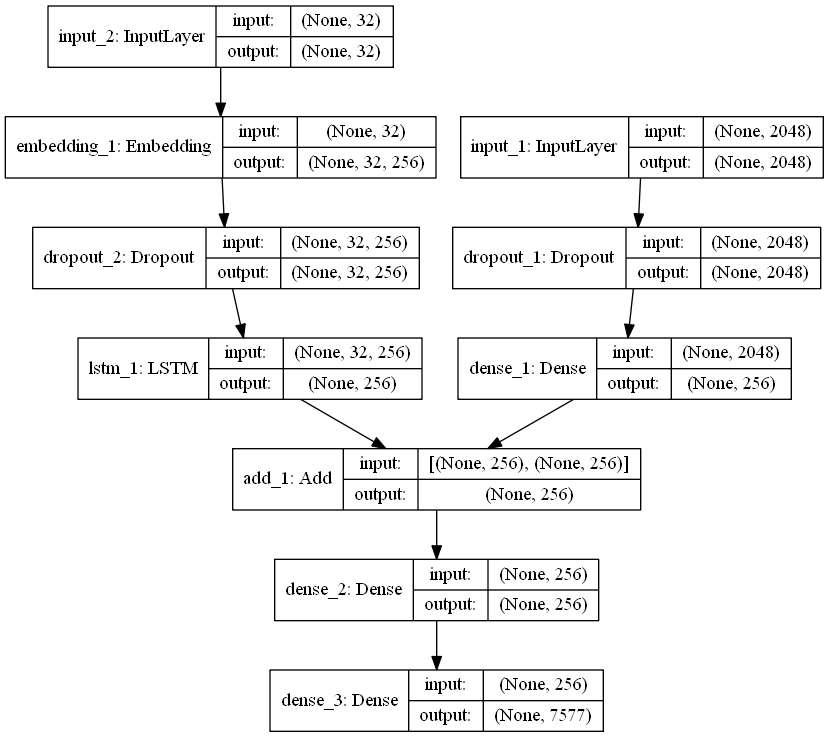

In [27]:
#Model
from keras.utils import plot_model

# defining the model
def caption_model(vocab_size,max_len):
    
    
    # features from the CNN model squeezed from 2048 to 256 nodes
    inputs1 = Input(shape=(2048,))
    fe1 = Dropout(0.5)(inputs1)
    fe2 = Dense(256, activation='relu')(fe1)
    
    # LSTM sequence model
    inputs2 = Input(shape=(max_length,))
    se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
    se2 = Dropout(0.5)(se1)
    se3 = LSTM(256)(se2)
    
    # Merging both models
    decoder1 = add([fe2, se3])
    decoder2 = Dense(256, activation='relu')(decoder1)
    outputs = Dense(vocab_size, activation='softmax')(decoder2)
    
    # tie it together [image, seq] [word]
    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam')
    # summarize model
    print(model.summary())
    plot_model(model, to_file='model.png', show_shapes=True)
    
    return model

# Training the model

To train the model, we will be using the 6000 training images by generating the input and output sequences in batches and fitting them to the model using model.fit_generator() method. We also save the model to our models folder. This will take some time depending on your system capability.

In [28]:
# train our model
print('Dataset: ', len(train_imgs))
print('Descriptions: train=', len(train_descriptions))
print('Photos: train=', len(train_features))
print('Vocabulary Size:', vocab_size)
print('Description Length: ', max_length)

model = caption_model(vocab_size, max_length)
epochs = 15
steps = len(train_descriptions)

filepath_loss="loss_on_val_set.hd5"
checkpoint_loss = ModelCheckpoint(filepath_loss, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

generator = data_generator(train_descriptions, train_features, tokenizer, max_length)
model.fit(generator, epochs=epochs, steps_per_epoch= steps, verbose=1,callbacks=[checkpoint_loss])

model.save("caption_model.h5")

Dataset:  6000
Descriptions: train= 6000
Photos: train= 6000
Vocabulary Size: 7577
Description Length:  32
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 32)]         0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 2048)]       0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 32, 256)      1939712     input_4[0][0]                    
__________________________________________________________________________________________________
dropout_2 (Dropout)             (None, 2048)         0           input_3[0][0]      

In [29]:
model.save("caption_model.h5")

# Testing the Model

In [30]:
pip install gTTS

Note: you may need to restart the kernel to use updated packages.


In [33]:
import IPython
import random




start two children are playing on the grass end


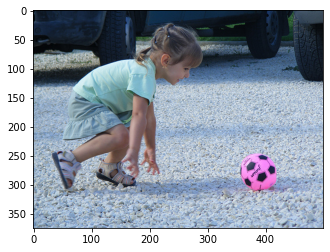

In [49]:
# Testing the model
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import argparse
# ap = argparse.ArgumentParser()
# ap.add_argument('-i', '--image', required=True, help="Image Path")
# args = vars(ap.parse_args())

path = '../input/flickr8k-imageswithcaptions/Flickr8k_Dataset/Flicker8k_Dataset'

# img_path = '../input/flickr8k-imageswithcaptions/Flickr8k_Dataset/Flicker8k_Dataset/218342358_1755a9cce1.jpg'

files=os.listdir(path)
d=random.choice(files)     #randomly choosing a single image
img_path=path + '/'+d



def extract_features(filename, model):
        try:
            image = Image.open(filename)
        except:
            print("ERROR: Couldn't open image! Make sure the image path and extension is correct")
        image = image.resize((299,299))
        image = np.array(image)
        # for images that has 4 channels, we convert them into 3 channels
        if image.shape[2] == 4: 
            image = image[..., :3]
        image = np.expand_dims(image, axis=0)
        image = image/127.5
        image = image - 1.0
        feature = model.predict(image)
        return feature
def word_for_id(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None
def generate_desc(model, tokenizer, photo, max_length):
    in_text = 'start'
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        pred = model.predict([photo,sequence], verbose=0)
        pred = np.argmax(pred)
        word = word_for_id(pred, tokenizer)
        if word is None:
            break
        in_text += ' ' + word
        if word == 'end':
            break
    return in_text



max_length = 32
tokenizer = load(open("tokenizer.p","rb"))
model = load_model('./caption_model.h5')
xception_model = Xception(include_top=False, pooling="avg")
photo = extract_features(img_path, xception_model)
img = Image.open(img_path)
description = generate_desc(model, tokenizer, photo, max_length)
print("\n\n")
print(description)
plt.imshow(img)
# Import the required module for text  
# to speech conversion 
from gtts import gTTS 


description=description[6:len(description)-4]

language = "en"
speech = gTTS(text = description, lang = language, slow = False)
speech.save("Audio.mp3")

# Playing the converted file 
IPython.display.Audio("Audio.mp3")



# Testing on our Own Image

In [ ]:
filename=''
